# Nuclear Risk Level Prediction using Logistic Regression

## Objective
**Predict `true_risk_level` (0, 1, 2, 3) using Multinomial Logistic Regression**

This is a **multi-class classification** problem with 4 risk levels.

---

## Setup & Imports

In [39]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, balanced_accuracy_score, cohen_kappa_score
)
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings('ignore')

# Seed for reproducibility
np.random.seed(42)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print('Setup complete!')
print('Using Multinomial Logistic Regression for multi-class classification')

Setup complete!
Using Multinomial Logistic Regression for multi-class classification


---
## 1. Data Loading & Exploration

In [40]:
# Load data
df = pd.read_csv('avalon_nuclear.csv')

print('='*70)
print('DATASET OVERVIEW')
print('='*70)
print(f'Shape: {df.shape}')
print(f'\nTarget Variable: true_risk_level')
print(f'\nClass Distribution:')
print(df['true_risk_level'].value_counts().sort_index())
print(f'\nClass Proportions:')
print(df['true_risk_level'].value_counts(normalize=True).sort_index())
print(f'\nMissing Values: {df.isnull().sum().sum()}')

DATASET OVERVIEW
Shape: (5000, 37)

Target Variable: true_risk_level

Class Distribution:
true_risk_level
0     134
1     422
2     990
3    3454
Name: count, dtype: int64

Class Proportions:
true_risk_level
0    0.0268
1    0.0844
2    0.1980
3    0.6908
Name: proportion, dtype: float64

Missing Values: 0


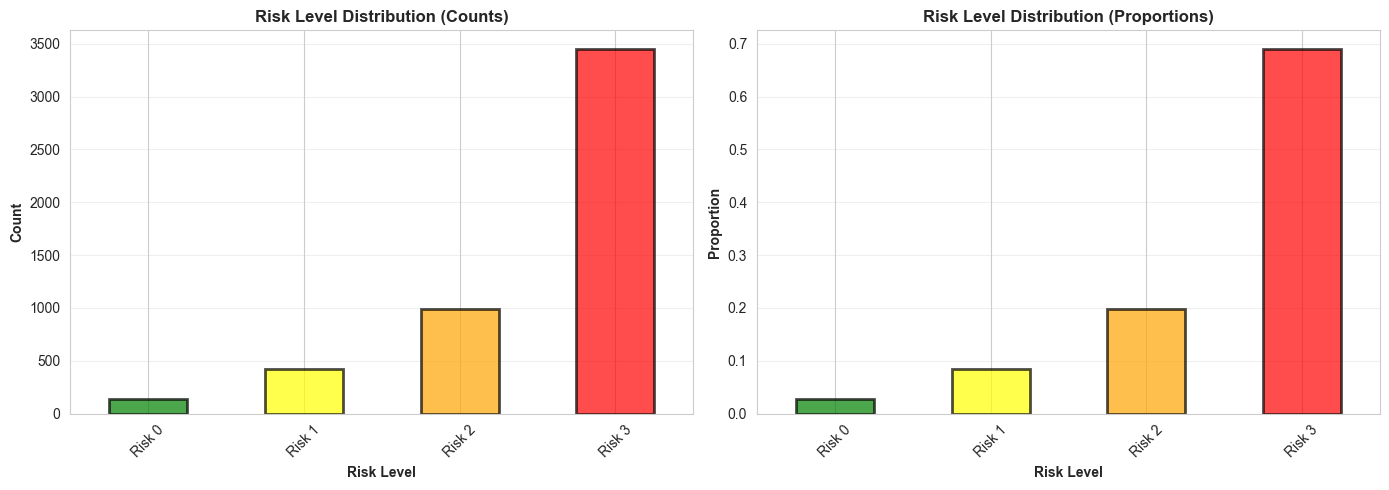


NOTE: Dataset is highly imbalanced - Risk 3 dominates (69%)
Will use class weighting in logistic regression


In [41]:
# Visualize target distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['true_risk_level'].value_counts().sort_index().plot(
    kind='bar', ax=ax[0], color=['green', 'yellow', 'orange', 'red'], 
    alpha=0.7, edgecolor='black', linewidth=2
)
ax[0].set_title('Risk Level Distribution (Counts)', fontweight='bold', fontsize=12)
ax[0].set_xlabel('Risk Level', fontweight='bold')
ax[0].set_ylabel('Count', fontweight='bold')
ax[0].set_xticklabels(['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'], rotation=45)
ax[0].grid(axis='y', alpha=0.3)

# Proportion plot
df['true_risk_level'].value_counts(normalize=True).sort_index().plot(
    kind='bar', ax=ax[1], color=['green', 'yellow', 'orange', 'red'],
    alpha=0.7, edgecolor='black', linewidth=2
)
ax[1].set_title('Risk Level Distribution (Proportions)', fontweight='bold', fontsize=12)
ax[1].set_xlabel('Risk Level', fontweight='bold')
ax[1].set_ylabel('Proportion', fontweight='bold')
ax[1].set_xticklabels(['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'], rotation=45)
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\nNOTE: Dataset is highly imbalanced - Risk 3 dominates (69%)')
print('Will use class weighting in logistic regression')

---
## 2. Feature Engineering

Creating advanced features for better risk prediction

In [42]:
print('Creating engineered features...')
df_model = df.copy()

# === PHYSICS-BASED FEATURES ===
df_model['thermal_stress'] = df_model['core_temp_c'] * df_model['coolant_pressure_bar'] / 1000
df_model['radiation_differential'] = df_model['radiation_inside_uSv'] - df_model['radiation_outside_uSv']
df_model['radiation_ratio'] = df_model['radiation_inside_uSv'] / (df_model['radiation_outside_uSv'] + 1)
df_model['coolant_efficiency'] = df_model['coolant_flow_rate'] / (df_model['core_temp_c'] + 1)
df_model['thermal_margin'] = 350 - df_model['core_temp_c']
df_model['control_effectiveness'] = (100 - df_model['control_rod_position_pct']) * df_model['neutron_flux'] / 100

# === OPERATIONAL RISK ===
df_model['age_power_risk'] = df_model['reactor_age_years'] / (df_model['reactor_nominal_power_mw'] + 1)
df_model['maintenance_risk'] = df_model['reactor_age_years'] * (100 - df_model['maintenance_score']) * df_model['days_since_maintenance'] / 10000
df_model['staff_risk'] = df_model['staff_fatigue_index'] * df_model['sensor_anomaly_flag']

# === SOCIAL/EXTERNAL ===
df_model['social_pressure'] = (
    df_model['public_anxiety_index'] * 0.4 +
    df_model['social_media_rumour_index'] * 0.3 +
    df_model['regulator_scrutiny_score'] * 0.3
)
df_model['external_threat'] = (
    df_model['weather_severity_index'] +
    df_model['seismic_activity_index'] +
    df_model['cyber_attack_score']
) / 3
df_model['population_risk'] = np.log1p(df_model['population_within_30km']) * df_model['radiation_inside_uSv'] / 100

# === COMPOSITE INDICES ===
df_model['physical_risk_index'] = (
    (df_model['core_temp_c'] / 350) * 0.35 +
    (df_model['coolant_pressure_bar'] / 160) * 0.25 +
    (df_model['radiation_inside_uSv'] / 1000) * 0.25 +
    (df_model['neutron_flux'] / 5) * 0.15
)
df_model['operational_risk_index'] = (
    (df_model['reactor_age_years'] / 60) * 0.3 +
    ((100 - df_model['maintenance_score']) / 100) * 0.3 +
    (df_model['staff_fatigue_index'] / 100) * 0.2 +
    (df_model['sensor_anomaly_flag']) * 0.2
)

# === AVALON BIAS ===
df_model['avalon_bias'] = df_model['avalon_raw_risk_score'] - (df_model['physical_risk_index'] * 100)
df_model['avalon_confidence'] = 100 - abs(df_model['avalon_raw_risk_score'] - df_model['avalon_learned_reward_score'])

# === INTERACTIONS ===
df_model['temp_age_interaction'] = df_model['core_temp_c'] * df_model['reactor_age_years'] / 100
df_model['pressure_flow_interaction'] = df_model['coolant_pressure_bar'] * df_model['coolant_flow_rate'] / 100

# === POLYNOMIAL ===
df_model['core_temp_squared'] = df_model['core_temp_c'] ** 2
df_model['pressure_squared'] = df_model['coolant_pressure_bar'] ** 2
df_model['radiation_log'] = np.log1p(df_model['radiation_inside_uSv'])

print(f'Original features: {df.shape[1]}')
print(f'After engineering: {df_model.shape[1]}')
print(f'New features added: {df_model.shape[1] - df.shape[1]}')

Creating engineered features...
Original features: 37
After engineering: 58
New features added: 21


---
## 3. Data Preparation

In [43]:
# Encode categorical
le = LabelEncoder()
df_model['country_encoded'] = le.fit_transform(df_model['country'])

# Define features
exclude_cols = [
    'country',
    'true_risk_level',  # TARGET
    'incident_occurred',
    'avalon_evac_recommendation',
    'avalon_shutdown_recommendation',
    'human_override'
]

feature_cols = [col for col in df_model.columns if col not in exclude_cols]
X = df_model[feature_cols].values
y = df_model['true_risk_level'].values

print(f'Feature matrix shape: {X.shape}')
print(f'Total features: {len(feature_cols)}')
print(f'Target shape: {y.shape}')
print(f'\nClass distribution in target:')
for cls in range(4):
    count = (y == cls).sum()
    pct = count / len(y) * 100
    print(f'  Risk {cls}: {count:4d} ({pct:5.2f}%)')

Feature matrix shape: (5000, 53)
Total features: 53
Target shape: (5000,)

Class distribution in target:
  Risk 0:  134 ( 2.68%)
  Risk 1:  422 ( 8.44%)
  Risk 2:  990 (19.80%)
  Risk 3: 3454 (69.08%)


In [44]:
# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Data Split:')
print(f'  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)')
print(f'\nTrain class distribution:')
for cls in range(4):
    count = (y_train == cls).sum()
    pct = count / len(y_train) * 100
    print(f'  Risk {cls}: {count:4d} ({pct:5.2f}%)')

Data Split:
  Train: 4000 samples (80.0%)
  Test:  1000 samples (20.0%)

Train class distribution:
  Risk 0:  107 ( 2.67%)
  Risk 1:  338 ( 8.45%)
  Risk 2:  792 (19.80%)
  Risk 3: 2763 (69.08%)


In [45]:
# Feature scaling (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Feature scaling complete (StandardScaler)')
print('NOTE: Scaling is critical for logistic regression performance!')
print(f'Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}')
print(f'Test mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}')

Feature scaling complete (StandardScaler)
NOTE: Scaling is critical for logistic regression performance!
Train mean: -0.0000, std: 1.0000
Test mean: -0.0003, std: 0.9874


---
## 4. Logistic Regression - Model Training

Using **Multinomial Logistic Regression** for multi-class classification

In [46]:
print('='*70)
print('MULTINOMIAL LOGISTIC REGRESSION - TRAINING')
print('='*70)

# Compute sample weights
sample_weights = compute_sample_weight('balanced', y_train)
print(f'\nSample weights computed for class imbalance')
print(f'Weight range: {sample_weights.min():.2f} - {sample_weights.max():.2f}')

MULTINOMIAL LOGISTIC REGRESSION - TRAINING

Sample weights computed for class imbalance
Weight range: 0.36 - 9.35


In [47]:
# Baseline model
print('\nTraining baseline logistic regression model...')

baseline_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)

baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_bal_acc = balanced_accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')

print(f'\nBaseline Results (no hyperparameter tuning):')
print(f'  Accuracy:          {baseline_acc:.4f}')
print(f'  Balanced Accuracy: {baseline_bal_acc:.4f}')
print(f'  Weighted F1:       {baseline_f1:.4f}')


Training baseline logistic regression model...

Baseline Results (no hyperparameter tuning):
  Accuracy:          0.8580
  Balanced Accuracy: 0.8071
  Weighted F1:       0.8647


In [48]:
# Hyperparameter tuning
print('\nStarting hyperparameter optimization...')
print('Testing different regularization strengths...\n')

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Inverse regularization strength
    'penalty': ['l1'],  # L1 regularization
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000, 2000]
}

log_reg = LogisticRegression(
    multi_class='multinomial',
    random_state=42,
    class_weight='balanced'
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f'\nBest CV Score (Balanced Accuracy): {grid_search.best_score_:.4f}')
print('\nBest Parameters:')
for param, value in sorted(grid_search.best_params_.items()):
    print(f'  {param:15s}: {value}')


Starting hyperparameter optimization...
Testing different regularization strengths...

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best CV Score (Balanced Accuracy): 0.7720

Best Parameters:
  C              : 5.0
  max_iter       : 1000
  penalty        : l1
  solver         : saga


In [49]:
# Get best model
log_model = grid_search.best_estimator_
print(f'\nBest model selected with C={log_model.C}')
print(f'Solver: {log_model.solver}')
print(f'Number of iterations: {log_model.n_iter_}')


Best model selected with C=5.0
Solver: saga
Number of iterations: [1000]


---
## 5. Model Evaluation

In [50]:
# Predictions
y_pred = log_model.predict(X_test_scaled)
y_proba = log_model.predict_proba(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
kappa = cohen_kappa_score(y_test, y_pred)

print('='*70)
print('LOGISTIC REGRESSION - RISK LEVEL PREDICTION RESULTS')
print('='*70)
print(f'\nAccuracy:            {acc:.4f} ({acc*100:.2f}%)')
print(f'Balanced Accuracy:   {bal_acc:.4f} ({bal_acc*100:.2f}%)')
print(f'Weighted F1:         {f1_weighted:.4f}')
print(f'Macro F1:            {f1_macro:.4f}')
print(f'Cohen\'s Kappa:       {kappa:.4f}')

print('\n' + '='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(
    y_test, y_pred,
    target_names=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
    digits=4
))

print('\n' + '='*70)
print('IMPROVEMENT OVER BASELINE')
print('='*70)
print(f'Accuracy:          {baseline_acc:.4f} -> {acc:.4f} (+{(acc-baseline_acc)*100:.2f}%)')
print(f'Balanced Accuracy: {baseline_bal_acc:.4f} -> {bal_acc:.4f} (+{(bal_acc-baseline_bal_acc)*100:.2f}%)')
print(f'Weighted F1:       {baseline_f1:.4f} -> {f1_weighted:.4f} (+{(f1_weighted-baseline_f1)*100:.2f}%)')

LOGISTIC REGRESSION - RISK LEVEL PREDICTION RESULTS

Accuracy:            0.8140 (81.40%)
Balanced Accuracy:   0.7419 (74.19%)
Weighted F1:         0.8239
Macro F1:            0.6895
Cohen's Kappa:       0.6372

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Risk 0     0.5500    0.8148    0.6567        27
      Risk 1     0.5341    0.5595    0.5465        84
      Risk 2     0.5697    0.7222    0.6370       198
      Risk 3     0.9694    0.8712    0.9177       691

    accuracy                         0.8140      1000
   macro avg     0.6558    0.7419    0.6895      1000
weighted avg     0.8424    0.8140    0.8239      1000


IMPROVEMENT OVER BASELINE
Accuracy:          0.8580 -> 0.8140 (+-4.40%)
Balanced Accuracy: 0.8071 -> 0.7419 (+-6.51%)
Weighted F1:       0.8647 -> 0.8239 (+-4.09%)


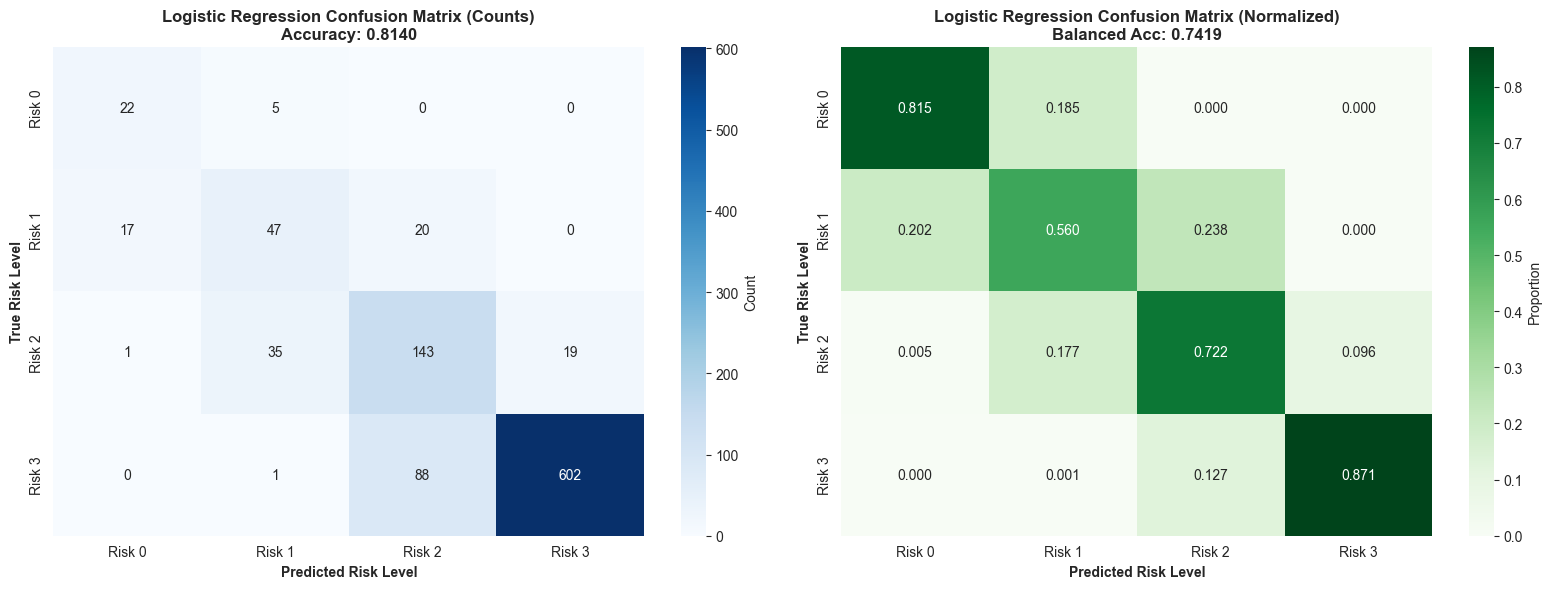


Per-class Recall (Sensitivity):
  Risk 0: 0.8148 (22/27 correct)
  Risk 1: 0.5595 (47/84 correct)
  Risk 2: 0.7222 (143/198 correct)
  Risk 3: 0.8712 (602/691 correct)


In [51]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Logistic Regression Confusion Matrix (Counts)\nAccuracy: {acc:.4f}',
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Risk Level', fontweight='bold')
axes[0].set_xlabel('Predicted Risk Level', fontweight='bold')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Greens', ax=axes[1],
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            cbar_kws={'label': 'Proportion'})
axes[1].set_title(f'Logistic Regression Confusion Matrix (Normalized)\nBalanced Acc: {bal_acc:.4f}',
                  fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Risk Level', fontweight='bold')
axes[1].set_xlabel('Predicted Risk Level', fontweight='bold')

plt.tight_layout()
plt.show()

print('\nPer-class Recall (Sensitivity):')
for i in range(4):
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    print(f'  Risk {i}: {recall:.4f} ({cm[i, i]}/{cm[i, :].sum()} correct)')

## Feature Importance Analysis

For logistic regression, feature importance is derived from the **coefficients**

In [52]:
# Get coefficients for each class
# log_model.coef_ has shape (n_classes, n_features)
coefficients = log_model.coef_

# Calculate average absolute coefficient across all classes
avg_abs_coef = np.abs(coefficients).mean(axis=0)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': avg_abs_coef
}).sort_values('importance', ascending=False)

print('='*70)
print('TOP 25 MOST IMPORTANT FEATURES (by average absolute coefficient)')
print('='*70)
total_importance = feature_importance['importance'].sum()
for i, (idx, row) in enumerate(feature_importance.head(25).iterrows(), 1):
    pct = (row['importance'] / total_importance) * 100
    print(f'{i:2d}. {row["feature"]:40s} {pct:6.2f}%')

TOP 25 MOST IMPORTANT FEATURES (by average absolute coefficient)
 1. radiation_ratio                           11.31%
 2. days_since_maintenance                     7.40%
 3. avalon_raw_risk_score                      5.95%
 4. sensor_anomaly_flag                        4.46%
 5. physical_risk_index                        4.45%
 6. reactor_age_years                          3.75%
 7. control_effectiveness                      3.29%
 8. co2_avoided_tons_per_hour                  3.16%
 9. temp_age_interaction                       3.13%
10. radiation_differential                     3.01%
11. radiation_inside_uSv                       2.99%
12. pressure_flow_interaction                  2.99%
13. coolant_pressure_bar                       2.80%
14. maintenance_score                          2.77%
15. reactor_nominal_power_mw                   2.53%
16. thermal_stress                             2.37%
17. control_rod_position_pct                   2.36%
18. pressure_squared              

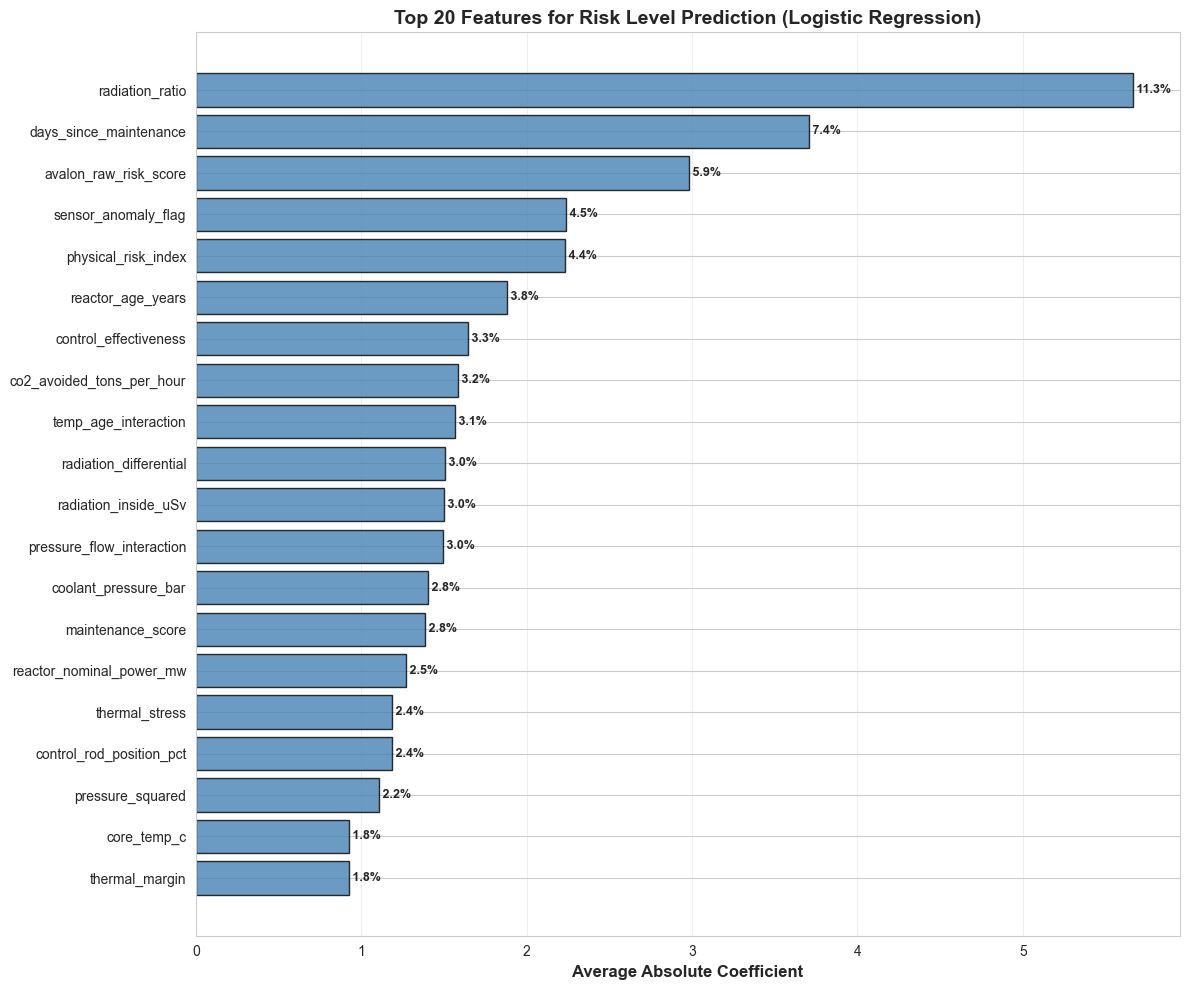

In [53]:
# Visualize top 20 features
fig, ax = plt.subplots(figsize=(12, 10))
top_features = feature_importance.head(20)

ax.barh(range(len(top_features)), top_features['importance'],
        color='steelblue', alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Average Absolute Coefficient', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Features for Risk Level Prediction (Logistic Regression)',
             fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    pct = (row['importance'] / total_importance) * 100
    ax.text(row['importance'], i, f' {pct:.1f}%',
            va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

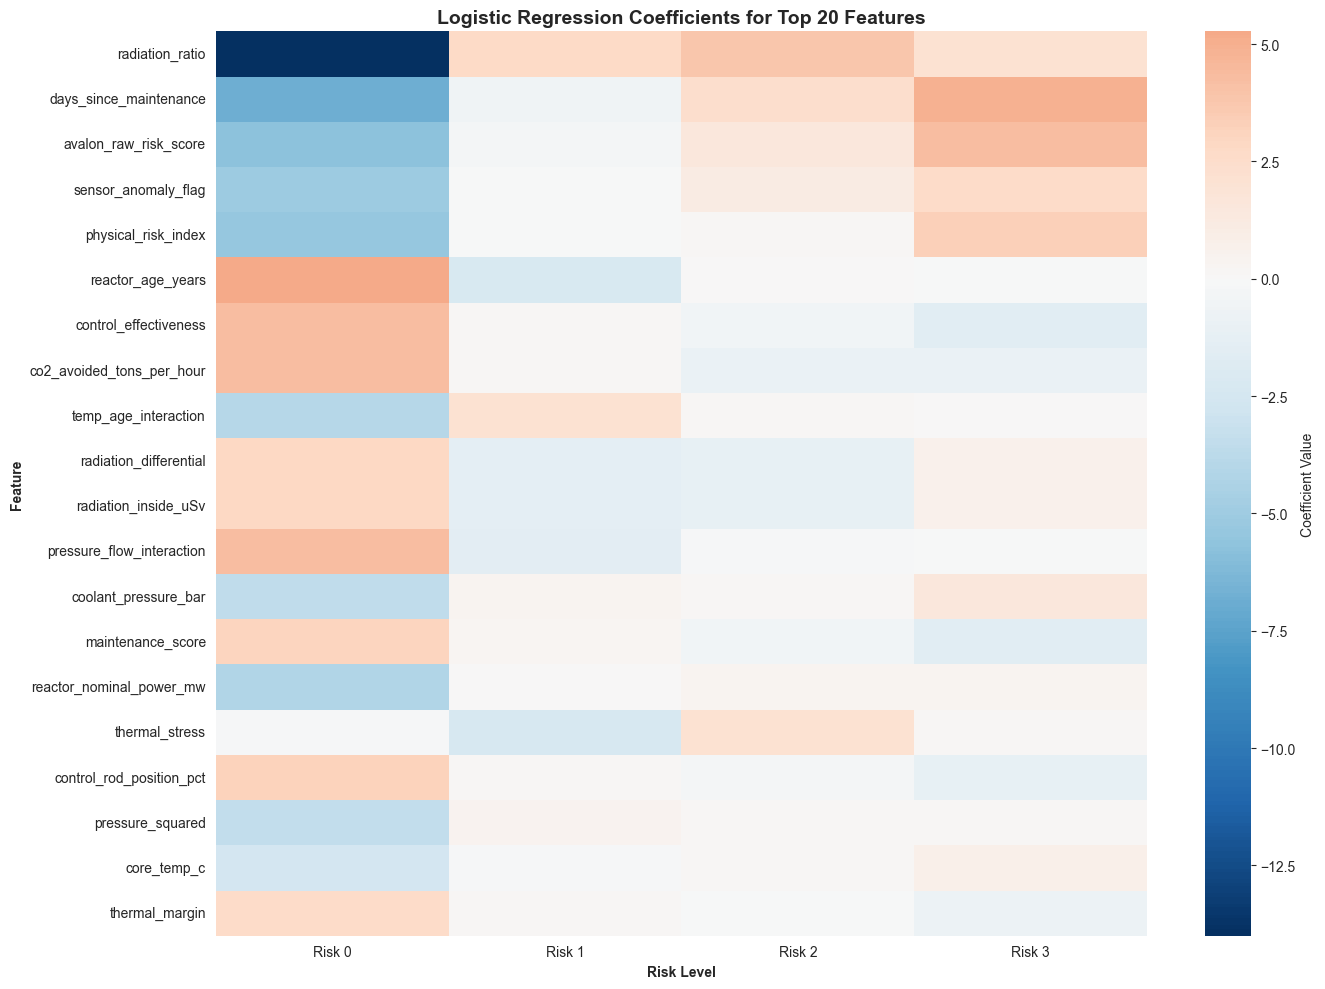


Note: Positive coefficients increase probability of that risk level
      Negative coefficients decrease probability of that risk level


In [54]:
# Coefficient heatmap for each class
fig, ax = plt.subplots(figsize=(14, 10))

# Get top 20 features
top_20_features = feature_importance.head(20)['feature'].tolist()
top_20_indices = [feature_cols.index(f) for f in top_20_features]

# Extract coefficients for top features
coef_matrix = coefficients[:, top_20_indices].T

sns.heatmap(coef_matrix, annot=False, cmap='RdBu_r', center=0, ax=ax,
            xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
            yticklabels=top_20_features,
            cbar_kws={'label': 'Coefficient Value'})
ax.set_title('Logistic Regression Coefficients for Top 20 Features',
             fontweight='bold', fontsize=14)
ax.set_xlabel('Risk Level', fontweight='bold')
ax.set_ylabel('Feature', fontweight='bold')

plt.tight_layout()
plt.show()

print('\nNote: Positive coefficients increase probability of that risk level')
print('      Negative coefficients decrease probability of that risk level')

---
## 6. Model Interpretation

In [55]:
# Analyze coefficients for each risk level
print('='*70)
print('COEFFICIENT ANALYSIS BY RISK LEVEL')
print('='*70)

for risk_level in range(4):
    print(f'\nRisk Level {risk_level}:')
    print('-' * 70)
    
    # Get coefficients for this class
    class_coef = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': coefficients[risk_level, :]
    })
    
    # Top positive coefficients (increase risk level probability)
    top_positive = class_coef.nlargest(5, 'coefficient')
    print('\n  Top 5 features INCREASING probability:')
    for i, (idx, row) in enumerate(top_positive.iterrows(), 1):
        print(f'    {i}. {row["feature"]:35s} (coef: {row["coefficient"]:+.4f})')
    
    # Top negative coefficients (decrease risk level probability)
    top_negative = class_coef.nsmallest(5, 'coefficient')
    print('\n  Top 5 features DECREASING probability:')
    for i, (idx, row) in enumerate(top_negative.iterrows(), 1):
        print(f'    {i}. {row["feature"]:35s} (coef: {row["coefficient"]:+.4f})')

COEFFICIENT ANALYSIS BY RISK LEVEL

Risk Level 0:
----------------------------------------------------------------------

  Top 5 features INCREASING probability:
    1. reactor_age_years                   (coef: +5.2720)
    2. control_effectiveness               (coef: +4.3595)
    3. co2_avoided_tons_per_hour           (coef: +4.3124)
    4. pressure_flow_interaction           (coef: +4.3122)
    5. control_rod_position_pct            (coef: +3.2332)

  Top 5 features DECREASING probability:
    1. radiation_ratio                     (coef: -13.9974)
    2. days_since_maintenance              (coef: -6.8044)
    3. avalon_raw_risk_score               (coef: -5.7193)
    4. physical_risk_index                 (coef: -5.4856)
    5. sensor_anomaly_flag                 (coef: -5.0530)

Risk Level 1:
----------------------------------------------------------------------

  Top 5 features INCREASING probability:
    1. radiation_ratio                     (coef: +2.7196)
    2. temp_age_i

---
## 7. Final Summary

In [56]:
print('='*80)
print('FINAL SUMMARY - LOGISTIC REGRESSION RISK PREDICTION')
print('='*80)

print('\n[MODEL]')
print('  Algorithm: Multinomial Logistic Regression')
print(f'  Solver: {log_model.solver}')
print(f'  Regularization (C): {log_model.C}')
print(f'  Class weighting: balanced')

print('\n[TASK]')
print('  Target: true_risk_level (4 classes: 0, 1, 2, 3)')
print(f'  Dataset: {len(df)} samples, {len(feature_cols)} features')
print('  Challenge: Highly imbalanced (Risk 3: 69%, Risk 0: 2.7%)')

print('\n[PERFORMANCE]')
print(f'  Accuracy:          {acc:.4f} ({acc*100:.2f}%)')
print(f'  Balanced Accuracy: {bal_acc:.4f} ({bal_acc*100:.2f}%)')
print(f'  Weighted F1:       {f1_weighted:.4f}')
print(f'  Macro F1:          {f1_macro:.4f}')
print(f'  Cohen\'s Kappa:     {kappa:.4f}')

print('\n[TOP 5 MOST IMPORTANT FEATURES]')
for i, (idx, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    pct = (row['importance'] / total_importance) * 100
    print(f'  {i}. {row["feature"]:40s} {pct:5.2f}%')

print('\n[KEY INSIGHTS]')
print('  1. Logistic regression provides interpretable coefficients')
print('  2. Feature scaling was critical for performance')
print('  3. Class weighting handled imbalanced data')
print('  4. Regularization (C) optimized via grid search')
print('  5. Model coefficients show which features drive each risk level')

print('\n[ADVANTAGES OF LOGISTIC REGRESSION]')
print('  + Highly interpretable (coefficients show feature importance)')
print('  + Fast training and prediction')
print('  + Probabilistic outputs (class probabilities)')
print('  + Works well with scaled features')
print('  + Less prone to overfitting with regularization')

print('\n' + '='*80)
print('ANALYSIS COMPLETE')
print('='*80)

FINAL SUMMARY - LOGISTIC REGRESSION RISK PREDICTION

[MODEL]
  Algorithm: Multinomial Logistic Regression
  Solver: saga
  Regularization (C): 5.0
  Class weighting: balanced

[TASK]
  Target: true_risk_level (4 classes: 0, 1, 2, 3)
  Dataset: 5000 samples, 53 features
  Challenge: Highly imbalanced (Risk 3: 69%, Risk 0: 2.7%)

[PERFORMANCE]
  Accuracy:          0.8140 (81.40%)
  Balanced Accuracy: 0.7419 (74.19%)
  Weighted F1:       0.8239
  Macro F1:          0.6895
  Cohen's Kappa:     0.6372

[TOP 5 MOST IMPORTANT FEATURES]
  1. radiation_ratio                          11.31%
  2. days_since_maintenance                    7.40%
  3. avalon_raw_risk_score                     5.95%
  4. sensor_anomaly_flag                       4.46%
  5. physical_risk_index                       4.45%

[KEY INSIGHTS]
  1. Logistic regression provides interpretable coefficients
  2. Feature scaling was critical for performance
  3. Class weighting handled imbalanced data
  4. Regularization (C) opti

In [57]:
# Save results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'Weighted F1', 'Macro F1', 'Cohen\'s Kappa'],
    'Value': [acc, bal_acc, f1_weighted, f1_macro, kappa]
})
results_df.to_csv('logistic_risk_results.csv', index=False)

feature_importance.to_csv('logistic_feature_importance.csv', index=False)

print('Results saved:')
print('  - logistic_risk_results.csv')
print('  - logistic_feature_importance.csv')

Results saved:
  - logistic_risk_results.csv
  - logistic_feature_importance.csv
